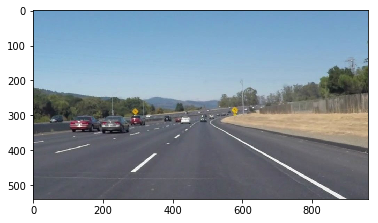

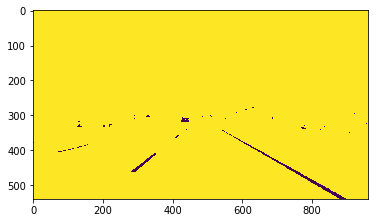

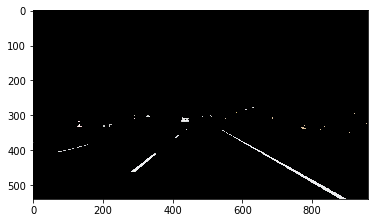

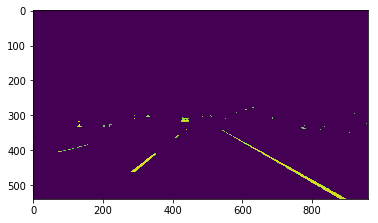

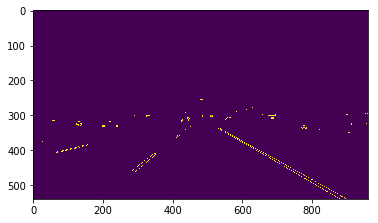

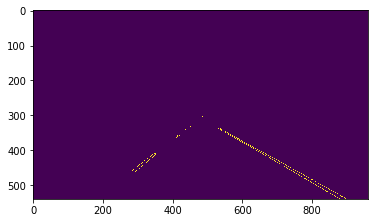

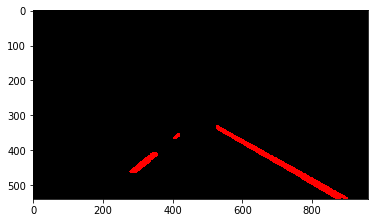

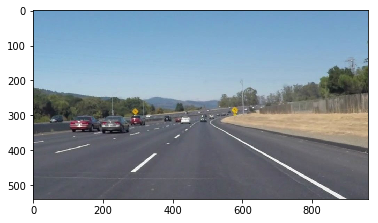

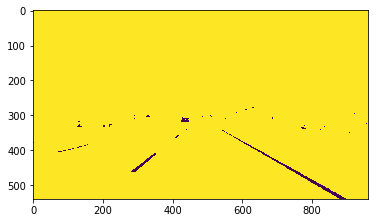

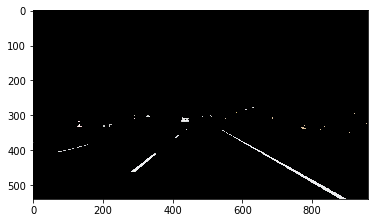

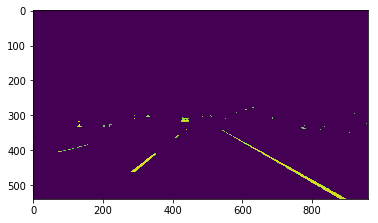

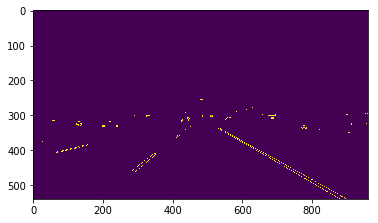

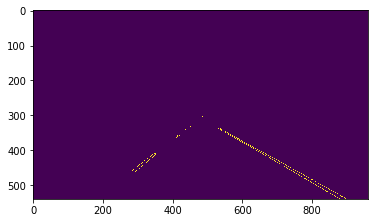

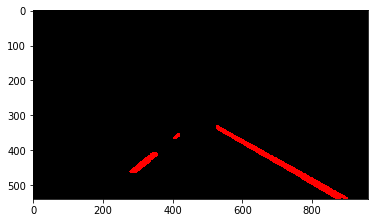

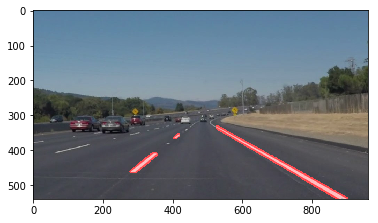

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML



def process_image(image):

    color_select = np.copy(image)
    line_image = np.copy(image)
    image_original = image
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    # MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
    red_threshold = 190
    green_threshold = 190
    blue_threshold = 0
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    left_bottom = [0, 539]
    right_bottom = [960, 539]
    #apex = [480, 270]
    apex = [480, 300]

    # Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Mask pixels below the threshold
    color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                        (image[:,:,1] < rgb_threshold[1]) | \
                        (image[:,:,2] < rgb_threshold[2])

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))

    # Mask color and region selection
    color_select[color_thresholds] = [0, 0, 0]
    #color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
    #line_image[~color_thresholds & region_thresholds] = [255, 0, 0]

    plt.imshow(image)
    plt.show()
    
    plt.imshow(color_thresholds)
    plt.show()

    plt.imshow(color_select)
    plt.show()

    #plt.imshow(line_image)
    #plt.show()
    image=color_select

    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    plt.imshow(gray)
    plt.show()

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    #plt.imshow(blur_gray)
    #plt.show()

    # Define our parameters for Canny and apply
    low_threshold = 255/3
    high_threshold = 255

    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    plt.imshow(edges)
    
    plt.show()

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    #plt.imshow(mask)
    #plt.show()

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    masked_edges[~region_thresholds] = 0
    plt.imshow(masked_edges)
    plt.show()
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 6    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)


    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    
    
    plt.imshow(line_image)
    plt.show()

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image_original, 0.8, line_image, 1, 0) 

    image = lines_edges
    return image

image_name='solidWhiteCurve'
#image_name='solidWhiteRight'
#image_name='solidYellowCurve'
#image_name='solidYellowCurve2'
#image_name='solidYellowLeft'
#image_name='whiteCarLaneSwitch'
existing_folder_name='orignal/'
New_foler_name='result/'

image = mpimg.imread(existing_folder_name+image_name+'.jpg')
cv2.imwrite(New_foler_name+image_name+"_result.jpg", process_image(image))


plt.imshow(process_image(image))
plt.show()
